#**Monte-Carlo Methods - Deforestation**



In this notebook we will solve a simple deforestation model in the view of a firm which wants to maximize its profits.


![Photo by Pok Rie from Pexels](https://drive.google.com/uc?id=1ZyDlOuX3dxp6QoWJUbUH0HULPG8qIpRd) (Photo by Pok Rie - Pexels)

A firm owns woodland with 50 units of wood. Every year there is a 50\% probability that $h = 1$ unit is lost due to tree diseases if there are still units of wood left.  The firm must decide how much wood to deforest each year. The firm can sell the wood at price $p$ per unit. The total cost of extracting $a$ units of wood in any year, given that the area contains $s$ units of wood at the beginning of the year is $c(s, a)$.

The market price $p = 1$, cost of extraction is $c(s, a) = a^2/(1+s)$, and annual discount factor $\gamma = 0.9$.





# **Model**


The units of wood $s$ is a discrete state variable:
- $s \in \{0, 1, 2, \dots, 50\}$


The action variable $a$ is the amount of deforested wood:
- $a \in \{0, 1, 2, \dots, \min(s, 10)\}$

The state transition function is:
- $t(s, a) = \max(s - a - 1, 0)$ with 50\% probability or
- $t(s, a) = s - a$ with 50\% probability

The reward function is:
- $r(s, a) = p\cdot a - c(s, a)$

# Environment

We are using Open AI Gym to create our environments. 

The Gym interface of an environment is described in [https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).

Next you will implement the deforestation model with the Open AI Gym framework, but first import all the necessary libraries for this notebook.  

In [2]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')


In [3]:
class DeforestationEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(DeforestationEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        n_actions = 11
        self.action_space = spaces.Discrete(n_actions)

        # In our simple model observation and state are synonyms
        self.initial_wood = 50
        self.observation_space = spaces.Discrete(self.initial_wood+1)

        self.price = 1

        self.rng = default_rng()
        
        
    def step(self, action):
        """State transition of the model.

        Args:
            action (int): Number of cleared wood

        Returns:
            state (numpy.ndarray): A shape-() array, number of remaining wood
            reward (int): Reward signal, which is here the utility
            done (bool): Indicating if terminal state is reached
            info (dict): Infos for debugging

        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        assert action <= self.state, "%r is to much extraction" % action


        reward = self.profit(self.state, action)

        # state transition
        self.state -= action 
        if self.state > 0:
            self.state -= self.rng.choice(2)

    

        # This is a episodic task, so done is true if the wood is deforested
        done = self.state == 0

        info = {}

        return np.array(self.state), reward, done, info

    def profit(self, state, action):
        """Calculates the profit of extracted ore
        
        Args:
            state (int): Current state, i.e. amount of ore
            action (int): Amount of extracted ore

        Returns:
            profit (int): Profit of extracted ore
        """
        
        return self.price*action - action**2/(1+state)
        

    def reset(self):
        """Resets the environment

        Initializes the state variable

        Returns:
            state (numpy.ndarray): A shape-() array
        
        """
        self.state = self.initial_wood
                      
        return np.array(self.state)


    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass


---


**Let's test our environment**


---


You can find the basic structure to simulate the environment in the [Open AI documentation](https://gym.openai.com/docs/).
 
Basically there are just 5 steps necessary, (see next cell).

Here we will use a fixed policy to simulate the episode.

Later in this notebook we will implement agents who learn good policies.



In [4]:
# 1st step: create the environment
env = DeforestationEnv()

# 2nd step: reset the environment
# here we save the initial fish contingent for the plot later
state = env.reset()
done = False

state_path = [state]

while not done:
    action = min(10, state)
    state, reward, done, _ = env.step(action)
    state_path.append(state)



---

**Plot the episode**


---



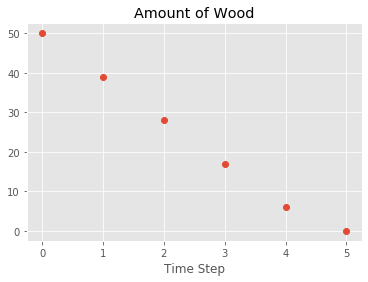

In [5]:
fig, ax = plt.subplots()

ax.set_xlabel('Time Step')
ax.set_title('Amount of Wood')

ax.plot(state_path, 'o');

# **Monte-Carlo Prediction**

In [6]:
def generate_episode(env, policy):
    """Generates an episode consisting of states, actions and rewards.

    Args:
        env (class): OpenAI Gym environment
        policy (numpy.ndarray): A shape-(n_states,) array, defines the action
            for every state

    Returns:
        states (numpy.ndarray): A shape-(episode_length+1,) array, contains
            all states starting with the initial state and ending with the
            terminal state
        actions (numpy.ndarray): A shape-(episode_length,) array, contains
            all actions taken in this episode
        rewards (numpy.ndarray): A shape-(episode_length,) array, contains
            all rewards received in this episode
    """

    state = env.reset()

    states = [state]
    actions = []
    rewards = []

    done = False
    while not done:
        # choose action according to policy and observe the new state and reward
        action = policy[states[-1]]
        state, reward, done, _ = env.step(action)

        # append the next state, action and reward to the corresponding list
        states.append(state)
        actions.append(action)
        rewards.append(reward)

    return np.array(states), np.array(actions), np.array(rewards)


In [7]:
def mc_prediction(env, policy, gamma, n_episodes=10000):
    """Implements first-visit Monte-Carlo policy evaluation algorithm.
    
    Calculates the corresponding value function of a policy.

    Args:
        env (class): OpenAI Gym environment.
        policy (numpy.ndarray): A shape-(n_states,) array, defines the action
            for every state.
        gamma (float): Discount factor.
        n_episodes (int): Number of simulated episodes.

    Returns:
        V (numpy.ndarray): A shape-(n_states,) array, value function which
            contains the value for every state.
    """
    
    n_states = env.observation_space.n

    V = np.zeros(n_states)

    state_count = np.zeros(n_states)
    
    for i in range(n_episodes):
        states, actions, rewards = generate_episode(env, policy)
        G = 0
        for t in reversed(range(len(actions))):
            G = gamma*G + rewards[t]
            if states[t] not in states[0:t]:
                state_count[states[t]] += 1
                V[states[t]] += 1/state_count[states[t]] * (G - V[states[t]])
    
    return V


In [8]:
env = DeforestationEnv()

gamma = 0.9

# define policy to evaluate
policy = np.minimum(np.arange(env.observation_space.n), 10)    

V = mc_prediction(env, policy, gamma)

In [9]:
V

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.85714286,  0.875     ,  0.88888889,  0.9       ,
        0.90909091,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  5.22421912,  5.53064308,  5.80503285,
        6.05210293,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 11.39611122, 11.76855059,
       12.11050686,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 17.92674531,
       18.30133746,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       24.34458371])

## **Stochastic policies**

Policy is now a matrix of size (n_states, n_actions).
If you want you can model the policy and the value functions as dictionary.

In [10]:
def weighted_choice(weights):
    """Weighted choice.

    Receives a sequence of numbers (weights) and returns randomly the index
    of the list weighted by the weights.

    Args:
        weights (numpy.ndarray): A shape-(number_of_weights,) array, 
            doesn't have to sum up to one.
    Returns:
        i (int): Index of array which is randomly chosen according to weights.
    """

    rnd = np.random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i

          
def generate_episode(env, policy):
    """Generates an episode consisting of states, actions and rewards.
    
    Generates the episode using a stochastic policy.

    Args:
        env (class): OpenAI Gym environment
        policy (numpy.ndarray): A shape-(n_states, n_actions) array, 
            defines the action for every state
        
    Returns:
        states (numpy.ndarray): A shape-(episode_length+1,) array, contains
            all states starting with the initial state and ending with the 
            terminal state.
        actions (numpy.ndarray): A shape-(episode_length,) array, contains
            all actions taken in this episode.
        rewards (numpy.ndarray): A shape-(episode_length,) array, contains
            all rewards received in this episode.
    """
    state = env.reset()
    
    states = [state]
    actions = []
    rewards = []

    done = False
    
    while not done:
        action = weighted_choice(policy[states[-1]])
        state, reward, done, _ = env.step(action)

        # append the next state, action and reward to the corresponding list
        states.append(state)
        actions.append(action)
        rewards.append(reward)

    return np.array(states), np.array(actions), np.array(rewards)


In [11]:
# create the environment
env = DeforestationEnv()
n_states = env.observation_space.n
n_actions = env.action_space.n
gamma = 0.9



In [12]:
# create the policy which should be evaluated
policy = np.ones((n_states, n_actions))/(np.minimum(np.arange(n_states), n_actions-1)[:,None]+1)
mask = np.tri(n_states, n_actions).astype(bool)
policy[~mask] = 0

policy

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.5       , 0.5       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.25      , 0.25      , 0.25      , 0.25      , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.

In [13]:
V = mc_prediction(env, policy, gamma)

In [14]:
V

array([ 0.        ,  0.32290898,  0.64181241,  0.95090992,  1.25912053,
        1.55629787,  1.86371745,  2.17920545,  2.45372441,  2.7772381 ,
        3.06693119,  3.65170385,  4.0988975 ,  4.65258349,  5.16277178,
        5.64612588,  6.16735192,  6.64362979,  7.15646368,  7.68939905,
        8.20496139,  8.73473126,  9.2423463 ,  9.8022157 , 10.27321587,
       10.8175571 , 11.34719025, 11.81033529, 12.41104715, 12.84405078,
       13.39948649, 13.91229768, 14.38038174, 14.83960268, 15.35389538,
       15.81305171, 16.2618703 , 16.81819496, 17.2237002 , 17.70178002,
       18.15509168, 18.65294441, 19.08318158, 19.46693131, 19.92172134,
       20.39482353, 20.6875505 , 21.25265765, 21.57459436, 22.06753174,
       22.40540842])

# **Estimating of Action Values**

In [15]:
def mc_prediction(env, policy, gamma, n_episodes=50000):
    """Implements first-visit Monte-Carlo policy evaluation algorithm.
    
    Calculates the corresponding action-value function of a policy.

    Args:
        env (class): OpenAI Gym environment
        policy (numpy.ndarray): A shape-(n_states,) array, defines the action
            for every state
        gamma (float): Discount factor
        n_episodes (int): Number of simulated episodes.

    Returns:
        Q (numpy.ndarray): A shape-(n_states, n_actions) array, 
            contains the value for every state, action pair
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    Q = np.zeros((n_states, n_actions))

    state_count = np.zeros((n_states, n_actions))
    
    for i in range(n_episodes):
        states, actions, rewards = generate_episode(env, policy)
        G = 0
        for t in reversed(range(len(actions))):
            G = gamma*G + rewards[t]
            if (states[t], actions[t]) not in zip(states[0:t], actions[0:t]):
                state_count[states[t], actions[t]] += 1
                Q[states[t], actions[t]] += 1/state_count[states[t], actions[t]] * (G - Q[states[t], actions[t]])
    
    return Q

In [16]:
Q = mc_prediction(env, policy, gamma)

In [17]:
Q

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.14584448,  0.5       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.43287573,  0.80969646,  0.66666667,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.71590628,  1.18305015,  1.14286339,  0.75      ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.97841457,  1.51751787,  1.62998059,  1.3489909 ,  0.8       ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.26688757,  1.82314381,  2.05354495,  1.91780359,  1.47500212,
         0.83333333,  0.        ,  0.        ,  0.        ,  0.        ,
         0.   

# **Monte-Carlo Control**

In [18]:
def mc_control(env, gamma, n_episodes=100000, epsilon=0.1):
    """Implements the policy iteration algorithm.

    Calculates the optimal policy and optimal action-value function.

    Args:
        env (class): OpenAI gym environment.
        gamma (int): Discount factor.
        n_episodes (int): Number of simulated episodes.
        epsilon (float): Exploration parameter.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # initialize action-value and policy function  
    Q = np.zeros((n_states, n_actions))
    policy = np.ones((n_states, n_actions))/(np.minimum(np.arange(n_states), n_actions-1)[:,None]+1)
    mask = np.tri(n_states, n_actions).astype(bool)
    policy[~mask] = 0

    state_count = np.zeros((n_states, n_actions))

    for _ in range(n_episodes):
        states, actions, rewards = generate_episode(env, policy)
        G = 0
        for t in reversed(range(len(actions))):
            G = gamma*G + rewards[t]
            if (states[t], actions[t]) not in zip(states[0:t], actions[0:t]):
                state_count[states[t], actions[t]] += 1
                Q[states[t], actions[t]] += 1/state_count[states[t], actions[t]] * (G - Q[states[t], actions[t]])

                # epsilon greedy policy improvement
                A_star = np.argmax(Q[states[t]])
                possible_actions = np.array([a for a in range(min(n_actions, states[t]+1))])
                policy[states[t], possible_actions] = epsilon/len(possible_actions)
                policy[states[t], A_star] += 1 - epsilon
    
    return Q, policy

Let's try the Monte-Carlo control algorithm.

In [19]:
Q, policy = mc_control(env, gamma, n_episodes=100000)

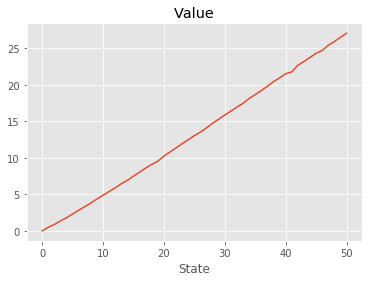

In [20]:
fig, ax = plt.subplots()

ax.set_xlabel('State')
ax.set_title('Value')

ax.plot(np.max(Q, axis=1));




# **Off-Policy Methods (optional)**

In [21]:
def off_policy_mc_prediction(env, target_policy, behaviour_policy, gamma, n_episodes=100000):
    """Implements off-policy Monte-Carlo policy evaluation algorithm.

    Args:
        env (class): OpenAI Gym environment.
        target_policy (numpy.ndarray): A shape-(n_states, n_actions) array.
        behaviour_policy (numpy.ndarray): A shape-(n_states, n_actions) array.
        gamma (int): Discount factor.
        n_episodes (int): Number of simulated episodes.

    Returns:
        Q (numpy.ndarray): A shape-(n_states, n_actions) array,
            evaluated action-value function according to target policy.

    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    Q = np.zeros((n_states, n_actions))

    # cumulative sum of weights
    C = np.zeros((n_states, n_actions))
    
    for i in range(n_episodes):
        states, actions, rewards = generate_episode(env, behaviour_policy)
        G = 0
        W = 1
        for t in reversed(range(len(actions))):
            G = gamma*G + rewards[t]

            C[states[t], actions[t]] += W
            Q[states[t], actions[t]] += W/C[states[t], actions[t]] * (G - Q[states[t], actions[t]])
            
            W = W*target_policy[states[t], actions[t]]/behaviour_policy[states[t], actions[t]]
            if W == 0:
                break
    return Q

In [22]:
env = DeforestationEnv()
num_states = env.observation_space.n
num_actions = env.action_space.n
gamma = 0.9

behaviour_policy = np.ones((num_states, num_actions))/(np.minimum(np.arange(num_states), num_actions-1)[:,None]+1)
mask = np.tri(num_states, num_actions).astype(bool)
behaviour_policy[~mask] = 0


target_policy = np.zeros((num_states, num_actions))
for i, row in enumerate(target_policy):
    row[min(i, 10)] = 1


In [23]:
Q = off_policy_mc_prediction(env, target_policy, behaviour_policy, gamma)

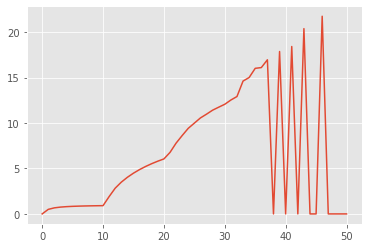

In [24]:
plt.plot(Q[np.arange(num_states), np.minimum(np.arange(num_states), 10)]);

In [25]:
def off_policy_mc_control(env, gamma, num_episodes=100000, epsilon=0.1):
    """Implements off policy Monte-Carlo Control algorithm.

    Args:
        env (class): OpenAI Gym environment.
        gamma (float): Discount factor.
        num_episodes (int): Number of simulated episodes.
        epsilon (float): Exploration parameter.

    Returns:
        Q (numpy.ndarray): A shape-(n_states, n_actions) array,
            action-value function
        target_policy (numpy.ndarray): A shape-(n_states, n_actions) array

    """
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    Q = np.zeros((num_states, num_actions))

    # cumulative sum of weights
    C = np.zeros((num_states, num_actions))

    behaviour_policy = np.ones((num_states, num_actions))/(np.minimum(np.arange(num_states), num_actions-1)[:,None]+1)
    mask = np.tri(num_states, num_actions).astype(bool)
    behaviour_policy[~mask] = 0

    target_policy = behaviour_policy.copy()
    
    for i in range(num_episodes):
        states, actions, rewards = generate_episode(env, behaviour_policy)
        G = 0
        W = 1
        for t in reversed(range(len(actions))):
            G = gamma*G + rewards[t]

            C[states[t], actions[t]] += W
            Q[states[t], actions[t]] += W/C[states[t], actions[t]] * (G - Q[states[t], actions[t]])

            A_star = np.argmax(Q[states[t]])
            possible_actions = np.array([a for a in range(min(num_actions, states[t]+1))])
            behaviour_policy[states[t], possible_actions] = epsilon/len(possible_actions)
            behaviour_policy[states[t], A_star] += 1 - epsilon

            target_policy[states[t]] = 0
            target_policy[states[t], A_star] = 1

            W = W*target_policy[states[t], actions[t]]/behaviour_policy[states[t], actions[t]]
            if W == 0:
                break
            
    return Q, target_policy

In [26]:
Q, pi = off_policy_mc_control(env, gamma)

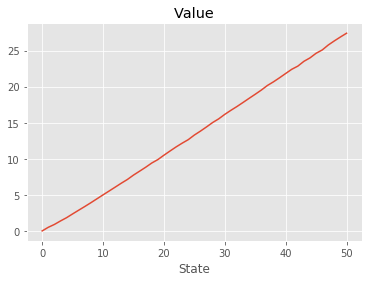

In [27]:
fig, ax = plt.subplots()

ax.set_xlabel('State')
ax.set_title('Value')

ax.plot(np.max(Q, axis=1));
